In [4]:
import tensorflow as tf
from tensorflow.contrib import slim

from preprocessing.preprocessing_factory import get_preprocessing
from nets import nets_factory

import os

In [5]:
import pandas as pd
import numpy as np

from skimage.io import imread, imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
MODEL = 'resnet_v2_152'

In [7]:
model = nets_factory.get_network_fn(MODEL, 10, is_training=True)

In [10]:
image_size = model.default_image_size

In [8]:
preprocessing_fn = get_preprocessing(MODEL, is_training=True)

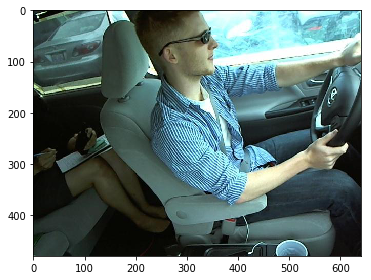

In [9]:
path = '../dataset_original/train/c0/img_100026.jpg'
img_raw = imread(path)
imshow(img_raw)

In [11]:
image = preprocessing_fn(img_raw, image_size, image_size)

In [13]:
with tf.Session() as sess:
    images = sess.run(image)

In [15]:
images.shape

(224, 224, 3)

In [16]:
imgs_list = pd.read_csv('../driver_imgs_list.csv')
paths_list = []
for i in range(len(imgs_list)):
    path = '../dataset_original/train/'+imgs_list.iloc[i]['classname']+'/'+imgs_list.iloc[i]['img']
    paths_list.append(path)

In [24]:
def load_image(paths, batch_size, MODEL, image_size):
    with tf.Graph().as_default() as graph:
        preprocessing_fn = get_preprocessing(MODEL, is_training=True)
        num_samples = len(paths)
        num_batch = num_samples // batch_size + 1
        for step in range(num_batch):
            start = step * batch_size
            end = min((step + 1) * batch_size, num_samples)
            path_batch = paths[start:end]
            img_batch = []
            for path in path_batch:
                img_raw = imread(path)
                img_p = preprocessing_fn(img_raw, image_size, image_size)
                with tf.Session() as sess:
                    img = list(sess.run(img_p))
                img_batch.append(img)
            yield np.array(img_batch)

In [25]:
for imgs in load_image(paths_list, 5, MODEL, image_size):
    print(imgs.shape)
    break

(5, 224, 224, 3)


In [28]:
with tf.Graph().as_default() as graph:
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs = tf.placeholder(tf.float32, [None, image_size, image_size, 3], name='input')
    
    logits, end_points = model(inputs)
    
    sv = tf.train.Supervisor(logdir='../log/tmp', summary_op=None)
    
    with sv.managed_session() as sess:
        i = 0
        for imgs in load_image(paths_list, 2, MODEL, image_size):
            logits_value = sess.run(logits, feed_dict={inputs: imgs})
            print(logits_value)
            i += 1
            if i == 2:
                break

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../log/tmp\model.ckpt
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ../log/tmp\model.ckpt
INFO:tensorflow:Starting queue runners.
[[-0.20362329  0.6399703   1.09245086  0.05453816 -0.34175441  0.60819793
  -0.67330486  0.68282968  0.41997343  0.5191415 ]
 [-0.16861901  0.63380682  0.751315    0.27926704  0.15446314  0.76952112
  -0.49050456  0.36795533  0.2497652   0.51815259]]
[[-0.2705465   0.59544766  0.86473906  0.21158165 -0.01161894  0.7521522
  -0.58427781  0.34227866  0.23049502  0.50572473]
 [-0.13286334  0.71800077  1.01188958  0.17371896 -0.2472364   0.63879794
  -0.6173358   0.63015789  0.4396809   0.51175773]]
